In [1]:
import hydra
import torch
import matplotlib.pyplot as plt
import numpy as np


from omegaconf import DictConfig, OmegaConf
from hydra.core.global_hydra import GlobalHydra
from hydra import compose, initialize


import sys

sys.path.append("../")

from complex_neural_source_localization.dataset import DCASE2019Task3Dataset, load_multichannel_wav, create_dataloaders
from complex_neural_source_localization.model import DOACNet
from complex_neural_source_localization.utils.model_visualization import (
    plot_multichannel_spectrogram,
    plot_spectrogram,
    plot_model_output,
    plot_real_feature_maps,
    plot_real_feature_map
)
from complex_neural_source_localization.trainer import DOACNetLightniningModule

def plot_mag_phase(features, unwrap=True):
    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
    axs[0].plot(features.abs())
    if unwrap:
        axs[1].plot(np.unwrap(features.angle().numpy()))
    else:
        axs[1].plot(features.angle().numpy())
    plt.show()

def scatter_complex(complex_vector):
    fig, ax = plt.subplots()
    ax.scatter(complex_vector.real, complex_vector.imag)

GlobalHydra.instance().clear()
initialize(config_path="../config")
config = compose("config")

MODEL_CHECKPOINT_PATH = "/Users/ezajlerg/datasets/complex_valued_source_localization/weights_big.ckpt"

In [2]:
dataset = create_dataloaders(config)[0] # 0=train | -1=test
dataset = iter(dataset)

model = DOACNetLightniningModule(config)
model.model.track_feature_maps()
model.eval()
checkpoint = torch.load(MODEL_CHECKPOINT_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["state_dict"], strict=False)


<All keys matched successfully>

In [3]:
batch = next(dataset)
model_output = model(batch[0])
predicted_azimuths = torch.atan2(model_output[:, 1], model_output[:, 0])
feature_maps = model.model.feature_maps

print("Ground truth azimuths:", batch[1]['azimuth_in_radians'])
print("Predicted azimuth:", predicted_azimuths)


Ground truth azimuths: tensor([[1.7453],
        [1.5708]])
Predicted azimuth: tensor([1.6984, 1.8882], grad_fn=<Atan2Backward0>)


Ground truth azimuth: tensor([1.5708])
Predicted azimuth: tensor(1.8882, grad_fn=<SelectBackward0>)


((<matplotlib.collections.QuadMesh at 0x7f82606f57c0>,
  <matplotlib.collections.QuadMesh at 0x7f8260762c40>),
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

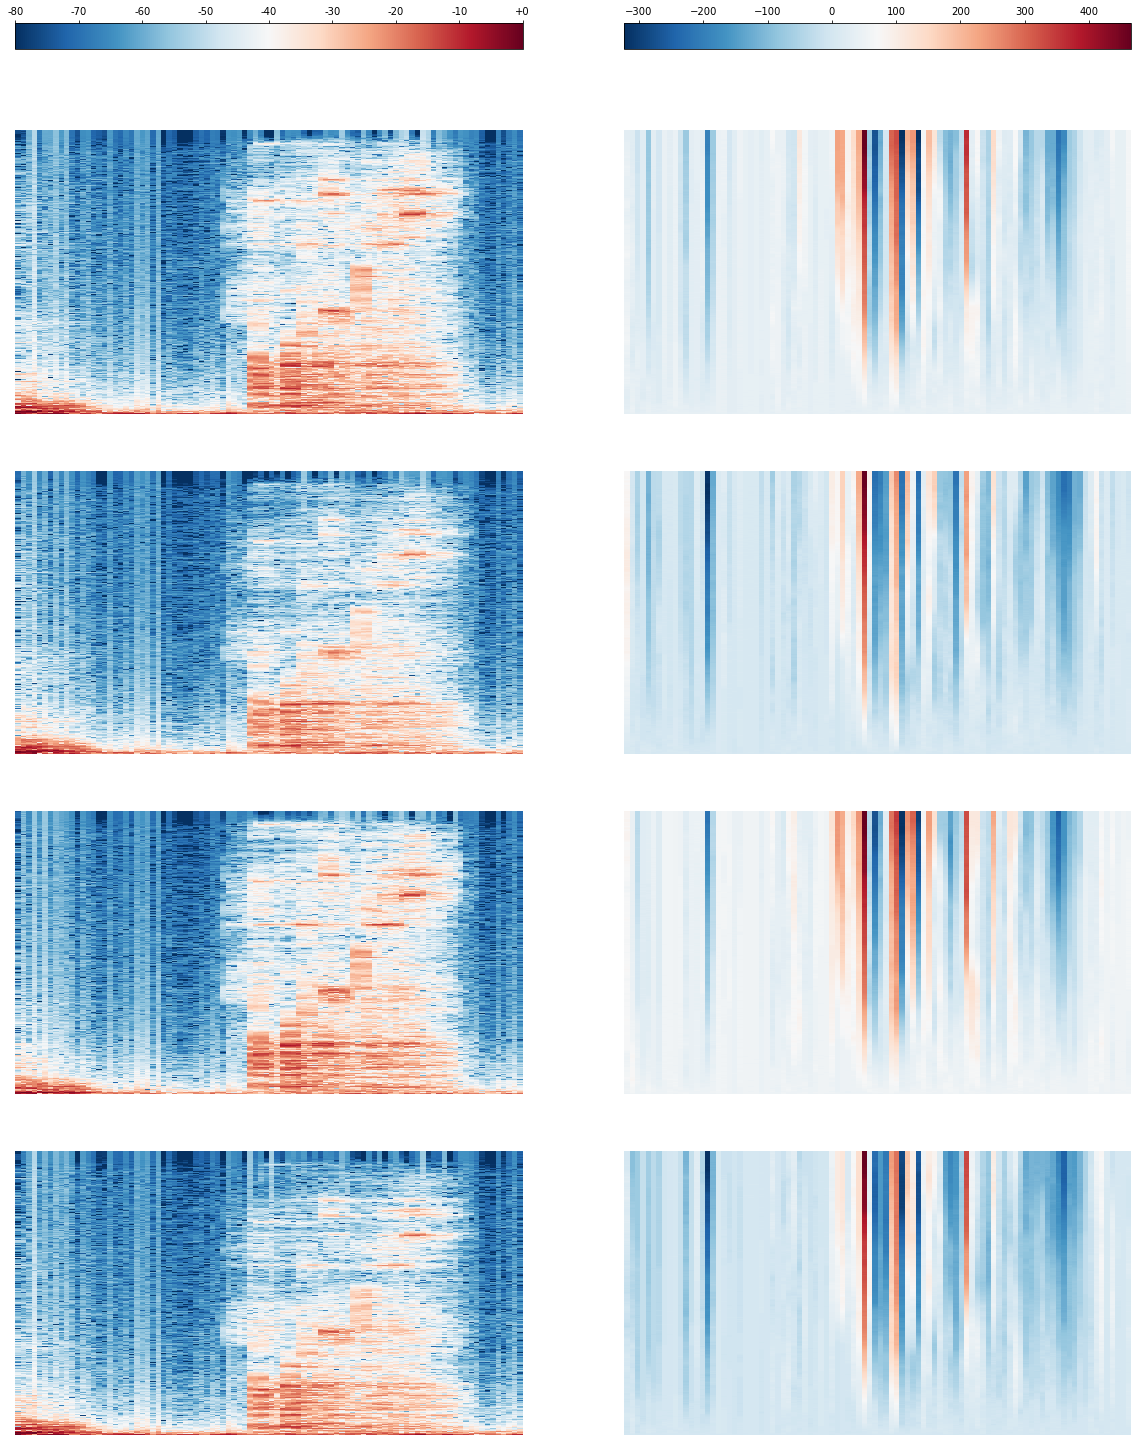

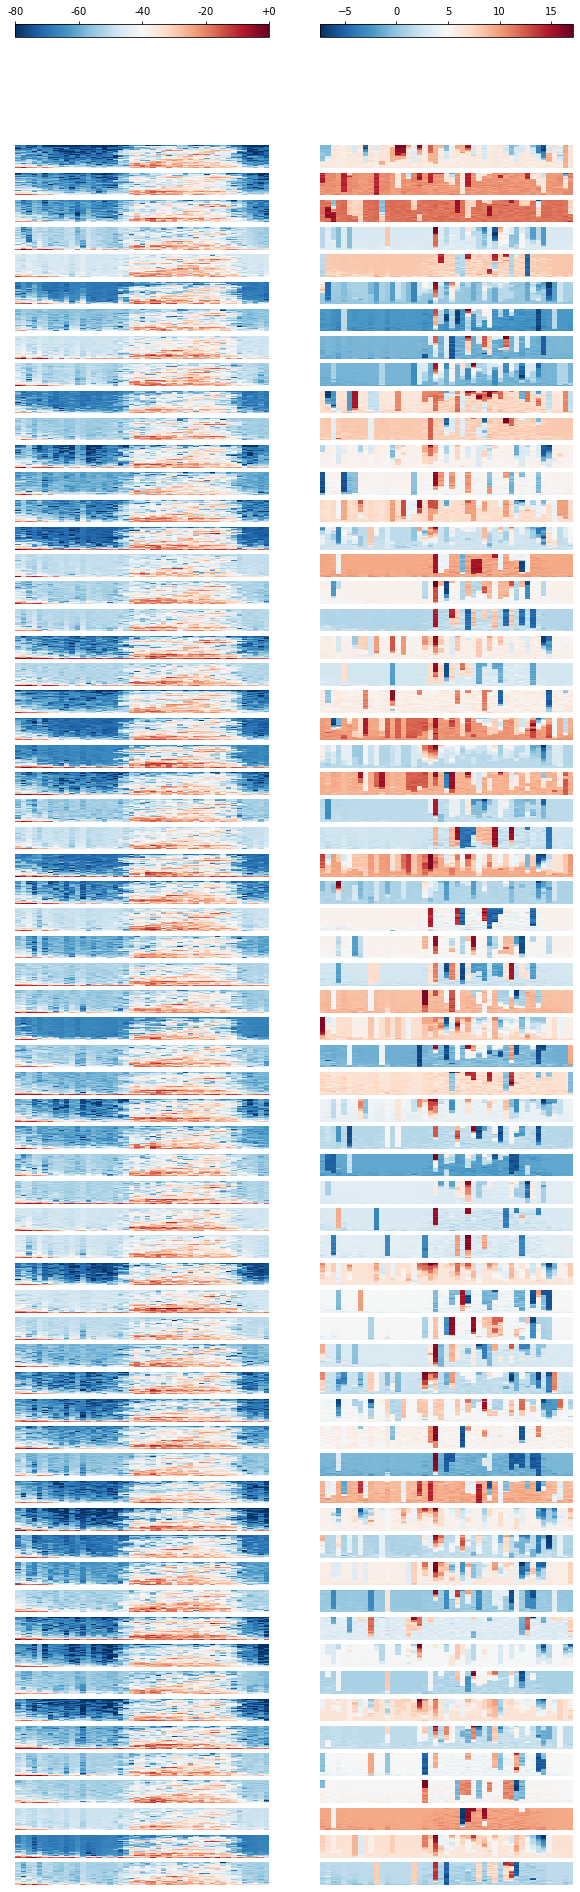

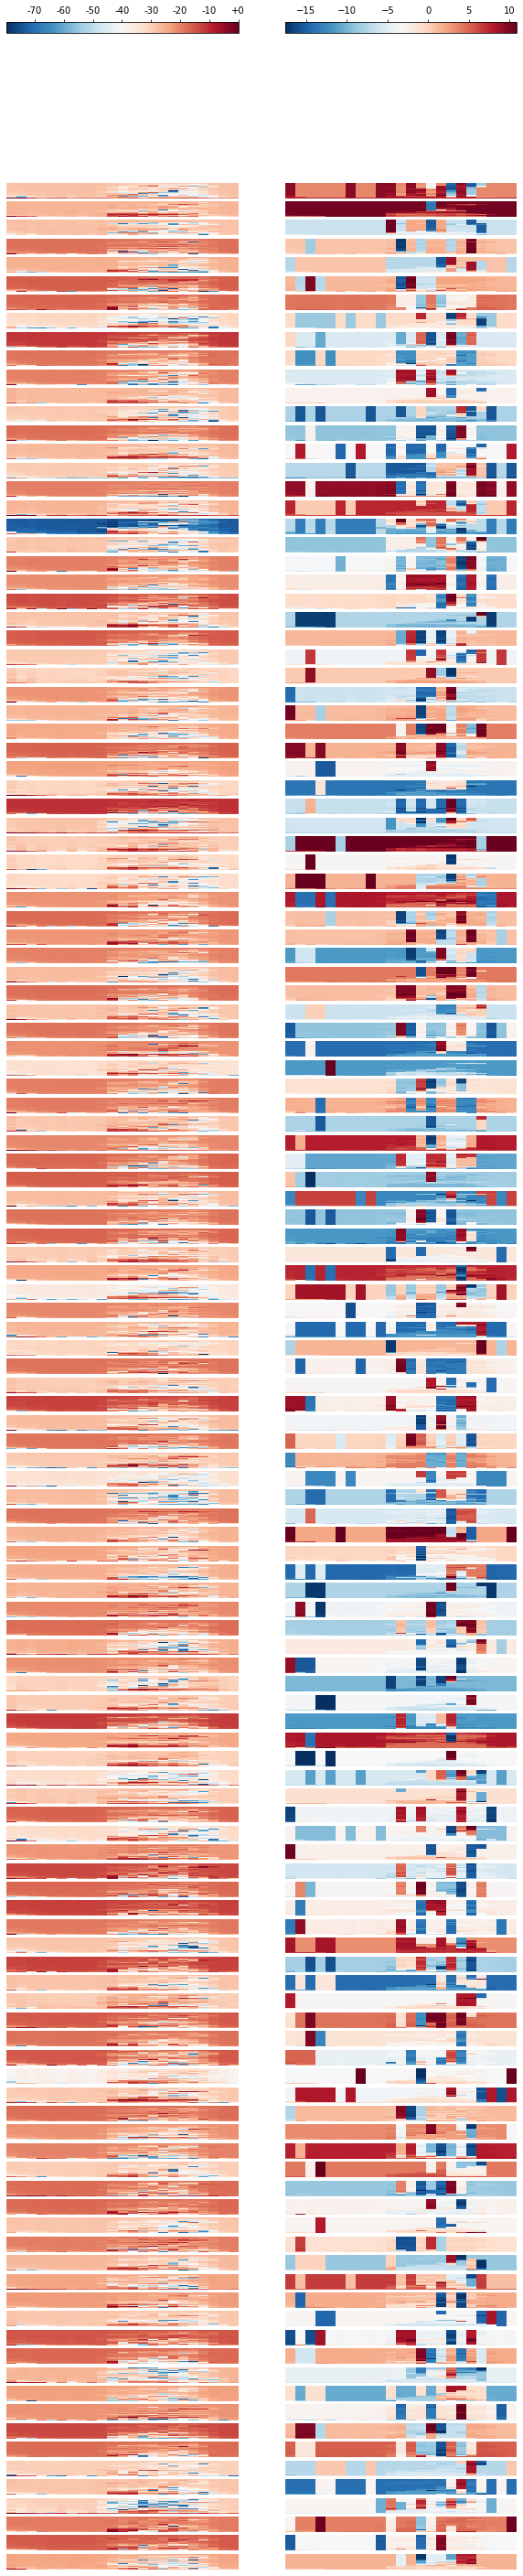

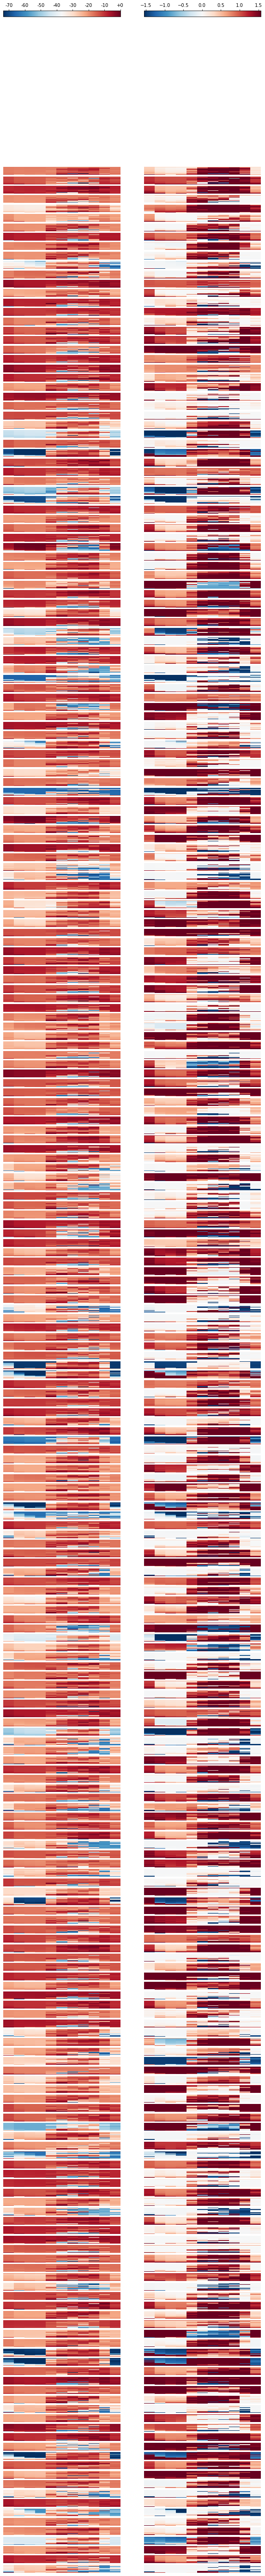

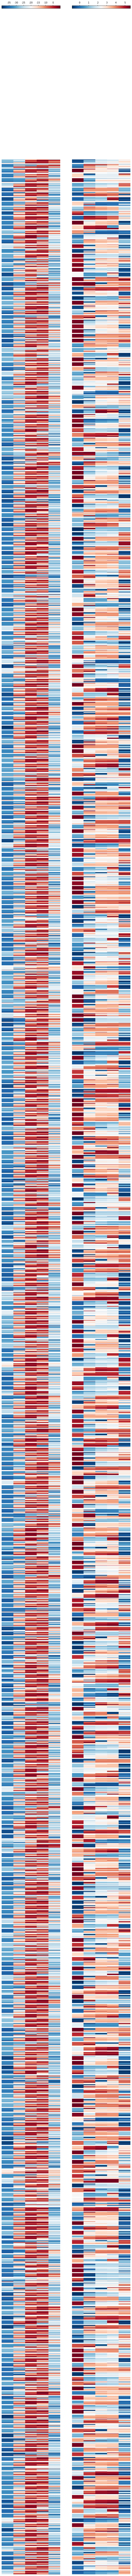

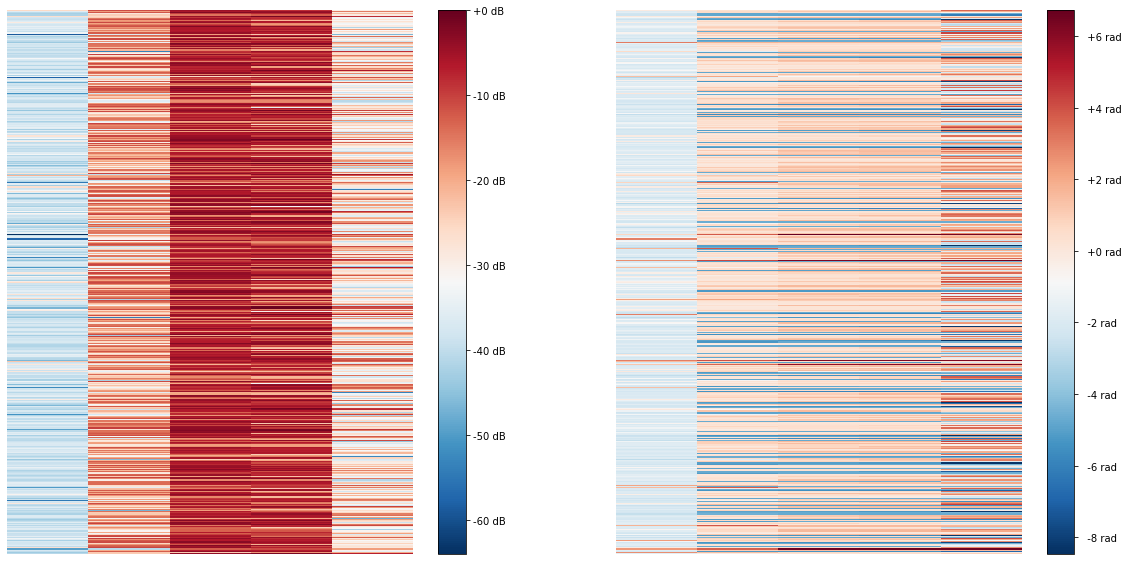

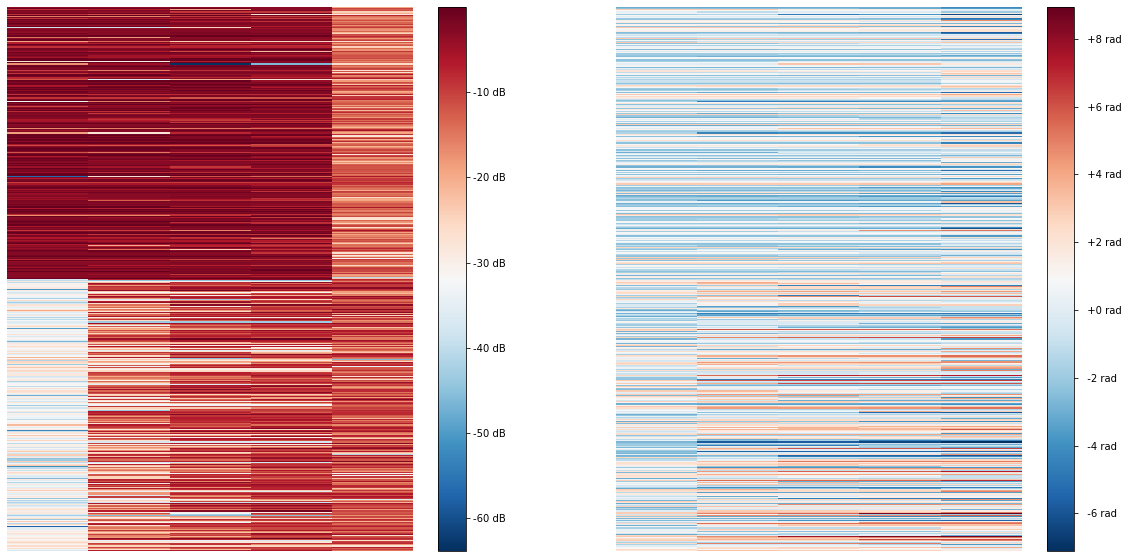

In [8]:
batch_idx = 1
print("Ground truth azimuth:", batch[1]['azimuth_in_radians'][batch_idx])
print("Predicted azimuth:", predicted_azimuths[batch_idx])

# 1. Plot input features
plot_multichannel_spectrogram(feature_maps["stft"][batch_idx], mode="row", figsize=(20, 30), close=False, unwrap=True)

# 2. Plot convolutional layers
plot_multichannel_spectrogram(feature_maps["conv_0"][batch_idx].transpose(-1, -2), close=False, mode="row",
                figsize=(10, 40), unwrap=True)
plot_multichannel_spectrogram(feature_maps["conv_1"][batch_idx].transpose(-1, -2), close=False, mode="row",
                figsize=(10, 60), unwrap=True)
plot_multichannel_spectrogram(feature_maps["conv_2"][batch_idx].transpose(-1, -2), close=False, mode="row",
                figsize=(10, 120), unwrap=True)
plot_multichannel_spectrogram(feature_maps["conv_3"][batch_idx].transpose(-1, -2), close=False, mode="row",
                figsize=(10, 240), unwrap=True)

mean_conv = torch.mean(feature_maps["conv_3"][batch_idx], dim=-1)
plot_spectrogram(mean_conv, close=False, mode="row",
                figsize=(20, 10), unwrap=True, unwrap_mode="time")

# 3. Plot recurrent layer
plot_spectrogram(feature_maps["rnn"][batch_idx].T, close=False, mode="row",
                figsize=(20, 10), unwrap=True, unwrap_mode="time")

# mean_rnn = torch.mean(feature_maps["rnn"][batch_idx], dim=0)
# plot_mag_phase(mean_rnn)

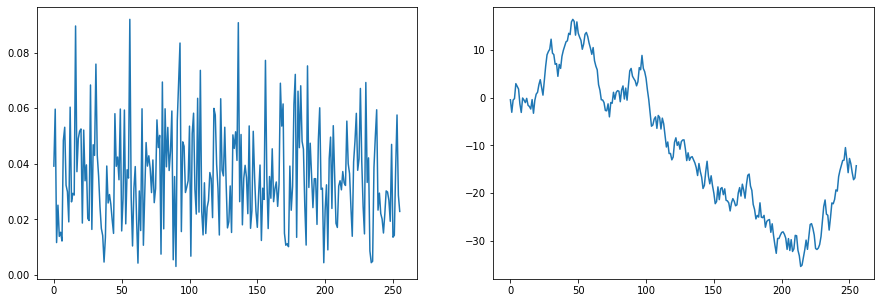

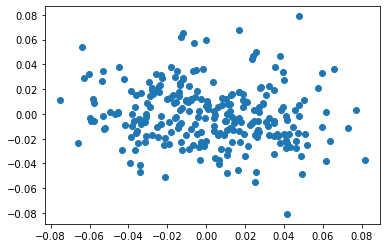

In [5]:
def get_params(model, prefix=""):
    params = {
        name: value for name, value in model.named_parameters()
        if name.startswith(prefix)
    }

    return params


params = get_params(model, "model.azimuth_fc")
linear_weights = torch.complex(params["model.azimuth_fc.fc_r.weight"],
                               params["model.azimuth_fc.fc_i.weight"])[0].detach()
bias_weights = torch.complex(params["model.azimuth_fc.fc_r.bias"],
                               params["model.azimuth_fc.fc_i.bias"]).detach()

plot_mag_phase(linear_weights[:linear_weights.shape[0]//2], unwrap=True)
scatter_complex(linear_weights[:linear_weights.shape[0]//2])

In [6]:
print(bias_weights)

tensor([0.0241-0.0274j])
